# Introduction

This notebook provides a simple interface for modelling radar returns of synthetic crystal orientation fabric profiles.

The radar model (Rathmann et al., 2021) consists of vertically stacked layers of anisotropic polycrystalline ice. Each layer is characterized by its bulk dielectric permittivity tensor
$$ 
\langle\boldsymbol{\epsilon}_{\mathrm{g}}\rangle = \frac{2\epsilon_\perp+\epsilon_\parallel}{3}\mathbf{I} 
+ (\epsilon_\parallel-\epsilon_\perp) \left(\langle\mathbf{c}\otimes\mathbf{c}\rangle - \frac{1}{3}\mathbf{I}\right), 
$$
where $\epsilon_\parallel$ and $\epsilon_\perp$ are the single-grain principal permittivities parallel and perpendicular to the optical $\mathbf{c}$-axis, and 
$$\langle\mathbf{c}\otimes\mathbf{c}\rangle = \int_{S^2} \mathbf{c}\otimes\mathbf{c} \,\psi \, \mathrm{d}\Omega$$
is the second-order structure tensor. 

In order to calculate $\langle\boldsymbol{\epsilon}_{\mathrm{g}}\rangle$ for each layer, the c-axis orientation distribution function (ODF), $\psi=\psi(\theta,\phi)$, must be provided for each layer. 
The layer-wise ODFs are modelled either (1) using a spectral fabric model (Rathmann et al. 2021, Rathmann and Lilien, 2021), or (2) by directly prescribing $\langle\mathbf{c}\otimes\mathbf{c}\rangle$ for each layer.

# Synthetic fabric profile

## Option 1: Using the fabric model 

The fabric model accounts for the effect on the ODF of kinematic lattice (c-axis) rotation (Svendsen and Hutter, 1996) and discontinuous dynamic recrystallization (DDRX) (Placidi and others, 2010):

$$ \frac{\mathrm{D} \psi}{\mathrm{D} t} + \nabla_{S^2}\cdot(\psi\mathbf{\dot{c}}) = \Gamma_0(D-\langle D \rangle) \psi + \nu\nabla^2\psi.$$

The parameters $\Gamma_0$ and $\nu$ specify the rate of DDRX and the strength of regularization, respectively. 
$\mathbf{\dot{c}}$ is the c-axis velocity field that depends on the macroscopic strain-rate and spin tensors, while $D$ is the single-grain deformability (normalized resolved shear stress squared) that depends on the deviatoric stress tensor (see Rathmann et al. (2021) and Rathmann and Lilien (2021) for details).

Vertical fabric profiles are synthesized by linearly transposing the time-scale of an ice-parcel deformation experiment onto a depth scale. 
Two consecutive modes of deformation must be specified per deformation experiment via the structures $\verb|mode1|$ and $\verb|mode2|$ below.

**Try out these three example profiles to get started:**


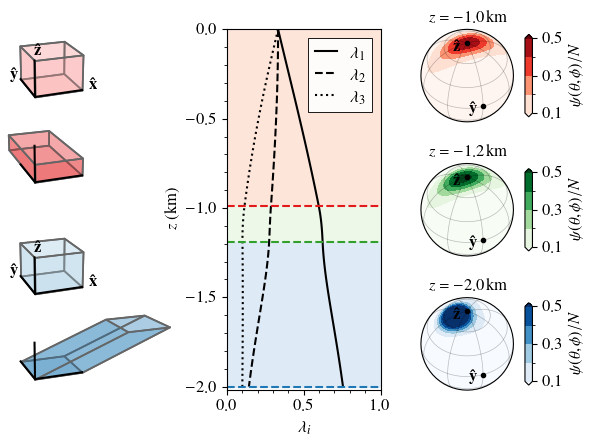

In [8]:
import numpy as np
from synthfabric import * # Requires specfabpy: pip3 install specfabpy

H        = 2000   # Ice column thickness
N_layers = 100    # Number of layers (for radar model below)
L        = 10     # Spectral truncation
nu       = 2.5e-3 # Regularization magnitude (to be adjusted depending on "L" and the time-scale "t_c" specified below)

synfab = SyntheticFabric(H=H, N=N_layers, L=L, nu=nu) 

"""
Specify the two modes of deformation by setting the fields of "mode1" and "mode2":


*** Pure shear: 
    ax        The compressional/extensional axis ("x", "y" or "z").
    t_c       Time (years) taken to halve the parcel height if t_c>0, or double if t_c<0.
    r=[-1;1]  Pure shear confinement: r=0 => unconfined, r=1 or r=-1 => 100% confinement in either of the non-"ax" directions.
    Gamma0    DDRX rate factor

*** Simple shear:
    plane     Shear plane ("zx" or "yx")
    t_c       Time (years) taken to reach a shear strain of 1
    Gamma0    DDRX rate factor

------

Calling synfab.makeProfile() requires passing:

    dt               Integration time step (years)
    t_end            Total integration time (years)
    crossover=[a,b]  Relative points in time over which the two deformational modes are linearly transitioned between.
    
"""

# Example 1
mode1 = {   'ax':'z',  't_c':500, 'r':-1, 'Gamma0':0}
mode2 = {'plane':'zx', 't_c':200,         'Gamma0':0}
nlm, z = synfab.makeProfile(mode1, mode2, dt=10, t_end=1000, crossover=[0.5,0.6], plot=True) 

# Example 2
#mode1 = {   'ax':'x',  't_c':-500, 'r':0, 'Gamma0':0}
#mode2 = {'plane':'zx', 't_c':200,        'Gamma0':0}
#nlm, z = synfab.makeProfile(mode1, mode2, dt=10, t_end=1000, crossover=[0.5,0.6], plot=True) 

# Example 3
#mode1 = {'plane':'yx', 't_c':500, 'Gamma0':0}
#mode2 = {'plane':'zx', 't_c':500, 'Gamma0':1e-9}
#nlm, z = synfab.makeProfile(mode1, mode2, dt=10, t_end=1000, crossover=[0.5,0.7], plot=True) 

## Option 2: Specifying the structure tensor profile

This method can be used if e.g. the structure tensor profile $\langle\mathbf{c}\otimes\mathbf{c}\rangle$ is already known. It is easier to set up and does not require the "specfabpy" module.

**Try out the below (constructed) non-symmetric vertical single-maximum profile**


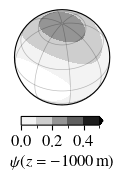

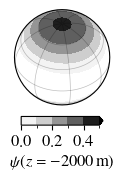

In [7]:
import numpy as np
import sys
sys.path.insert(0, '../../lib') # Add model library path
from layerstack import c2_to_nlm

### Construct structure tensor profile

H        = 2000   # Ice column thickness
N_layers = 100+1  # Number of layers (for radar model below)

z   = np.linspace(0,-H, N_layers) # Interface positions
c2  = np.zeros((N_layers,3,3))    # 3x3 matrix per layer. Note equivelent notations: c2 = <c^2> := a^(2)
nlm = np.zeros((N_layers,6))      # Spectral ODF coefficients corresponding to <c^2>

lambdavec = np.linspace(1/3, 0.9, N_layers) # Principal eigen value (lambda_1) with depth
c2[:,0,0] = 2/10*(1-lambdavec) 
c2[:,1,1] = 8/10*(1-lambdavec)
c2[:,2,2] = lambdavec

for ii in np.arange(N_layers):
    nlm[ii,:], lm = c2_to_nlm(c2[ii,:,:]) # Convert <c^2> to spectral coefficients n_2^m

nlm[0, 1:] = 0 # Ensure the top layer is isotropic (required by model)

### Plot ODFs

from plottools import plot_ODF

I = int(N_layers/2)
plot_ODF(nlm[I,:], lm, tickintvl=2, cblabel=r'$\psi(z=\SI{%i}{\metre})$'%(z[I]));

I = int(N_layers)-1
plot_ODF(nlm[I,:], lm, tickintvl=2, cblabel=r'$\psi(z=\SI{%i}{\metre})$'%(z[I]));

# Radar power returns

To calculate the radar returns 

* $\bar{P}_{ij}$          : Mean return power for Tx and Rx polarizations of $i=\lbrace \mathrm{H,V}\rbrace$ and $j=\lbrace \mathrm{H,V}\rbrace$, respectively
* $\delta{P}_{ij}$        : Angular power anomaly for Tx and Rx polarizations of $i=\lbrace \mathrm{H,V}\rbrace$ and $j=\lbrace \mathrm{H,V}\rbrace$, respectively
* $\varphi_{\mathrm{HV}}$ : H$-$V Covariance phase angle

given the above fabric profile, run:


Initialized "GTM" layer stack: frames x layers = 50 x 100


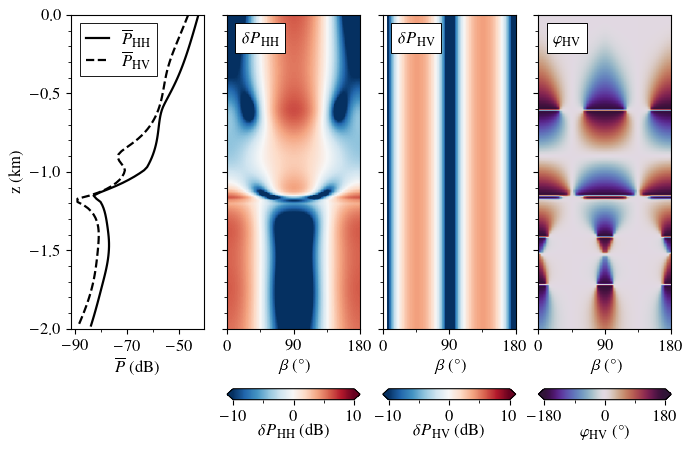

In [9]:
import sys
sys.path.insert(0, '../../lib') # Add model library path
from layerstack import *
from plottools import *

epsa     = 3.17         # Single grain permittivity perpendicular to c-axis
epsc     = epsa - 0.034 # Single grain permittivity parallel to c-axis
sigma    = 1e-5         # Isotropic macroscopic conductivity
N_frames = 50           # Number of horizontally rotated frames (beta) between 0 and Pi 

lstack = LayerStack(nlm, z, N_frames=N_frames, epsa=[epsa], epsc=[epsc], sigma=[sigma]) # Assumes constant epsa, epsc and sigma throughout the column if len()==1

E0       = 1e3   # Tx E-field amplitude
f        = 179e6 # Tx frequency in Hertz
alpha    = 0     # Angle of incidence in radians (0 = normal incidence)

returns = lstack.get_returns(E0, f=f, alpha=alpha) # returns (Pm_HH,Pm_HV, dP_HH,dP_HV, c_HHVV, E_HH,E_HV)

plot_returns(lstack.z, returns)